<a href="https://colab.research.google.com/github/Allekarthik/AIML_Projects_and_labs/blob/main/AIML_4_exercise_Module1_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [3]:
def plotGrid(transform, unit, linestyle=":", fig=None, ax=None):
    lim1 = -100
    lim2 = 100

    def mat2xy(start, end):
        if len(start.shape) == 1:
            start = np.expand_dims(start, 0)
            end = np.expand_dims(end, 0)
        nan = np.ones(len(start)) * np.nan
        x = np.stack((start[:, 0], end[:, 0], nan)).T.reshape(-1)
        y = np.stack((start[:, 1], end[:, 1], nan)).T.reshape(-1)
        return x, y

    def parallellines(axis, addend, lines, unit):
        addend = np.repeat(np.expand_dims(addend, 0), lines * 2, 0)
        unit = np.expand_dims(np.arange(-lines, lines) * unit, 1)
        unit = unit - lines
        addend = addend * unit
        lines = np.expand_dims(axis, 0) + addend
        return np.concatenate((lines, lines * -1))

    if fig is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    transform = transform.astype(float)
    xaxis = transform[0]
    yaxis = transform[1]


    lines1 = parallellines(xaxis * lim1, yaxis, 100, unit)
    lines2 = parallellines(xaxis * lim2, yaxis, 100, unit)
    x, y = mat2xy(lines1, lines2)
    plt.plot(x, y, linestyle + "k", linewidth=0.5)

    x, y = mat2xy(xaxis * lim1, xaxis * lim2)
    plt.plot(x, y, linestyle, color="#440077")


    lines1 = parallellines(yaxis * lim1, xaxis, 100, unit)
    lines2 = parallellines(yaxis * lim2, xaxis, 100, unit)
    x, y = mat2xy(lines1, lines2)
    plt.plot(x, y, linestyle + "k", linewidth=0.5)

    x, y = mat2xy(yaxis * lim1, yaxis * lim2)
    plt.plot(x, y, linestyle, color="#aa5500")

    return fig, ax

def plotData(X, y, xlabel="hole", ylabel="bound", fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots()
    for ii in range(nclasses):
        plt.scatter(X[y == ii, 0], X[y == ii, 1])
    plt.legend([str(i) for i in range(nclasses)])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    lim2 = X.max()
    lim1 = X.min()
    return fig, ax

In [4]:
def dist(a, b):
    diff = a - b
    sq = diff * diff
    return np.sqrt(sq.sum())

def NN1(traindata, trainlabel, query):
    diff = traindata - query
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label


In [5]:
def NN(traindata, trainlabel, testdata):
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel

def Accuracy(gtlabel, predlabel):
    assert len(gtlabel) == len(predlabel)
    correct = (gtlabel == predlabel).sum()
    return correct / len(gtlabel)

def cumArray(img):
    img2 = img.copy()
    for ii in range(1, img2.shape[1]):
        img2[ii, :] = img2[ii, :] + img2[ii - 1, :]
    img2 = img2 > 0
    return img2


In [7]:
def getHolePixels(img):
    im1 = cumArray(img)
    im2 = np.rot90(cumArray(np.rot90(img)), 3)
    im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
    im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
    hull = im1 & im2 & im3 & im4
    hole = hull & ~(img > 0)
    return hole

def getBoundaryPixels(img):
    img = img.copy() > 0
    rshift = np.roll(img, 1, 1)
    lshift = np.roll(img, -1, 1)
    ushift = np.roll(img, -1, 0)
    dshift = np.roll(img, 1, 0)
    boundary = (
        minus(img, rshift)
        | minus(img, lshift)
        | minus(img, ushift)
        | minus(img, dshift)
    )
    return boundary

def minus(a, b):
  return a & ~b

In [8]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255
test_X = test_X / 255

nclasses = 4

In [9]:
train_X = train_X[train_y < nclasses]
train_y = train_y[train_y < nclasses]
test_X = test_X[test_y < nclasses]
test_y = test_y[test_y < nclasses]

train_X = train_X[::100].copy()
train_y = train_y[::100].copy()
test_X = test_X[::100].copy()
test_y = test_y[::100].copy()

In [10]:
train_hole = np.array([getHolePixels(i).sum() for i in train_X])
test_hole = np.array([getHolePixels(i).sum() for i in test_X])
train_bound = np.array([getBoundaryPixels(i).sum() for i in train_X])
test_bound = np.array([getBoundaryPixels(i).sum() for i in test_X])


In [11]:
train_feats = np.vstack((train_hole, train_bound)).transpose()
test_feats = np.vstack((test_hole, test_bound)).transpose()

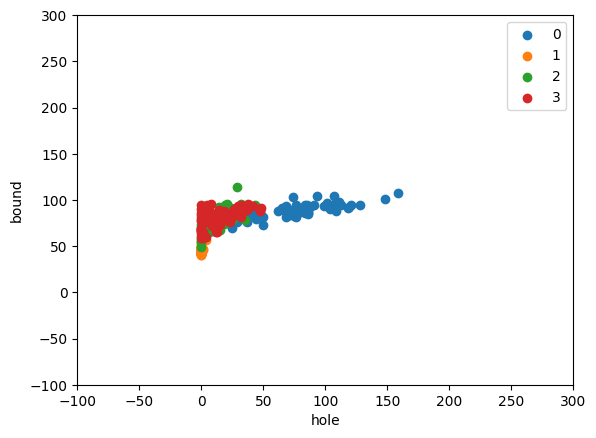

Baseline accuracy: 76.19047619047619 % for 4 classes


In [12]:
xlim = [-100, 300]
ylim = [-100, 300]

fig, ax = plotData(train_feats, train_y)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

test_pred = NN(train_feats, train_y, test_feats)
acc = Accuracy(test_y, test_pred)
print("Baseline accuracy:", acc * 100, "%", "for", nclasses, "classes")


In [13]:
transformation_matrices = [
    np.array([[1, 0], [0, 1]]),
    np.array([[0.5, -0.5], [0, 2.5]]),
    np.array([[2, 1], [1, 3]]),
    np.array([[0.2, -0.2], [0, 1.5]])
]


Transformation Matrix:
 [[1 0]
 [0 1]]


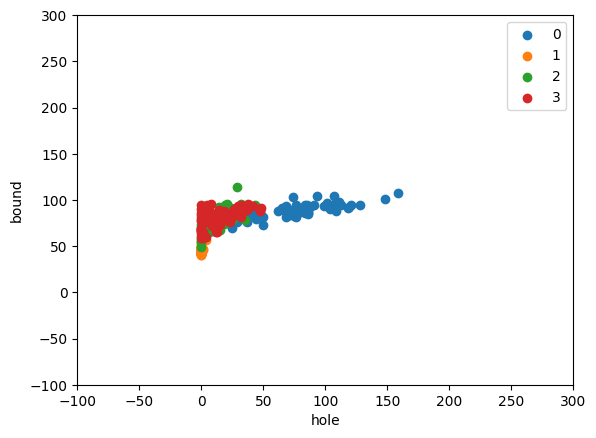

Accuracy: 76.19047619047619 % for 4 classes with transformation:
 [[1 0]
 [0 1]]

Transformation Matrix:
 [[ 0.5 -0.5]
 [ 0.   2.5]]


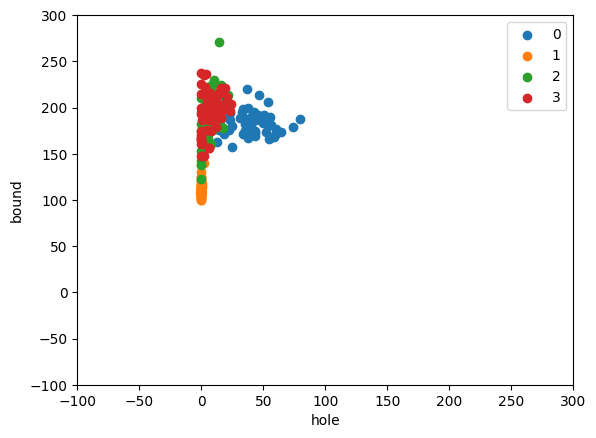

Accuracy: 80.95238095238095 % for 4 classes with transformation:
 [[ 0.5 -0.5]
 [ 0.   2.5]]

Transformation Matrix:
 [[2 1]
 [1 3]]


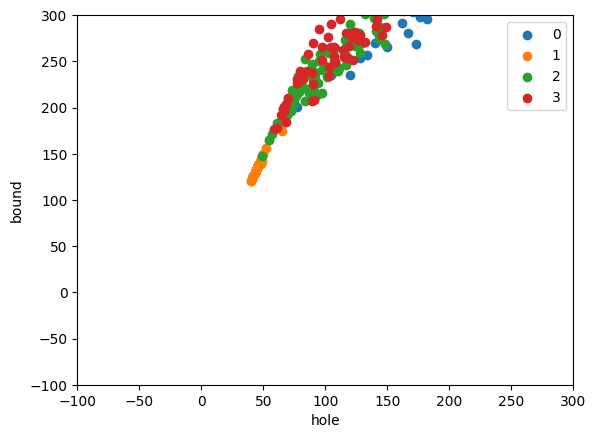

Accuracy: 76.19047619047619 % for 4 classes with transformation:
 [[2 1]
 [1 3]]

Transformation Matrix:
 [[ 0.2 -0.2]
 [ 0.   1.5]]


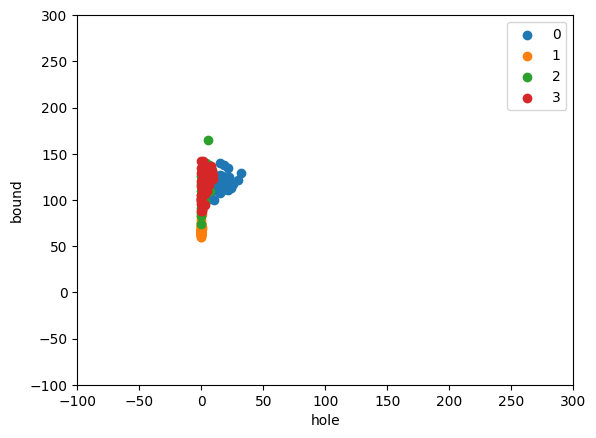

Accuracy: 78.57142857142857 % for 4 classes with transformation:
 [[ 0.2 -0.2]
 [ 0.   1.5]]


In [14]:
for transform in transformation_matrices:
    print("\nTransformation Matrix:\n", transform)
    train_feats_t = np.matmul(train_feats, transform)
    test_feats_t = np.matmul(test_feats, transform)

    fig, ax = plotData(train_feats_t, train_y)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

    test_pred = NN(train_feats_t, train_y, test_feats_t)
    acc = Accuracy(test_y, test_pred)
    print("Accuracy:", acc * 100, "%", "for", nclasses, "classes with transformation:\n", transform)

Will the same transform used for these two features also work for other features?

if the same transformation can be applied to other features as well but its effectivenes depend on nature of the class
here i added convex hull pixels and sum of pixels let us see with code


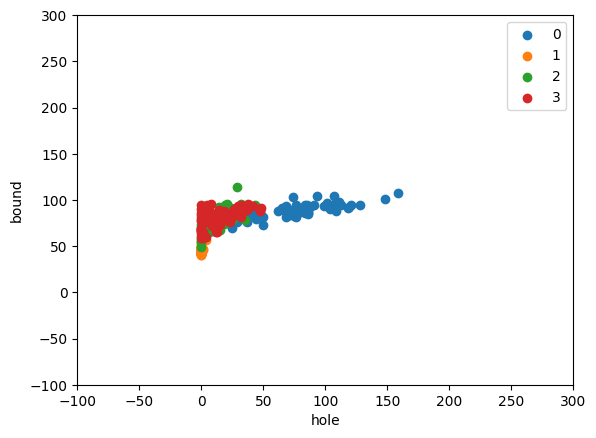

Baseline accuracy with hole and boundary features: 76.19047619047619 % for 4 classes


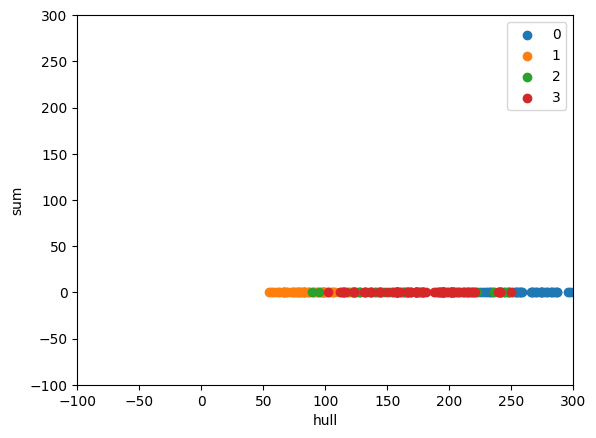

Baseline accuracy with hull and sum features: 66.66666666666666 % for 4 classes

Transformation Matrix:
 [[1 0]
 [0 1]]

Transformation Matrix:
 [[ 0.5 -0.5]
 [ 0.   2.5]]

Transformation Matrix:
 [[2 1]
 [1 3]]

Transformation Matrix:
 [[ 0.2 -0.2]
 [ 0.   1.5]]


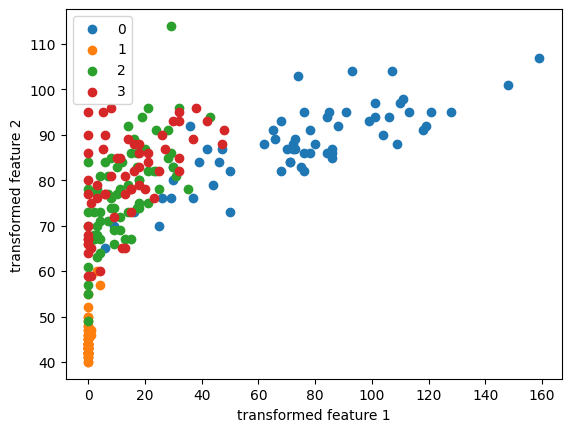

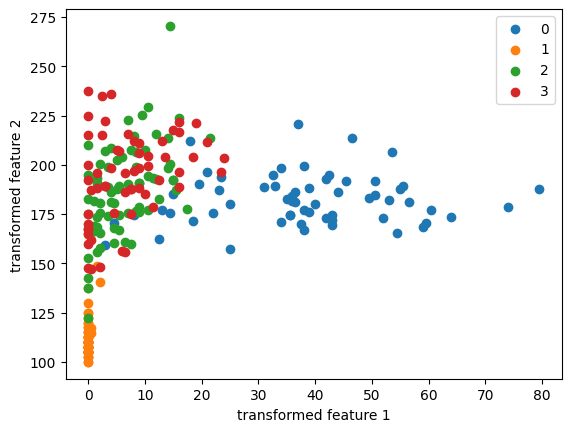

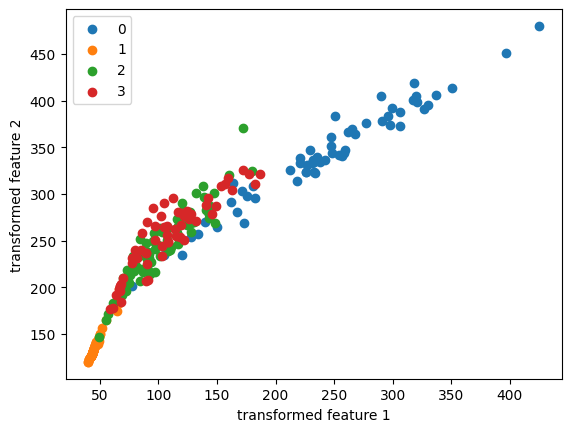

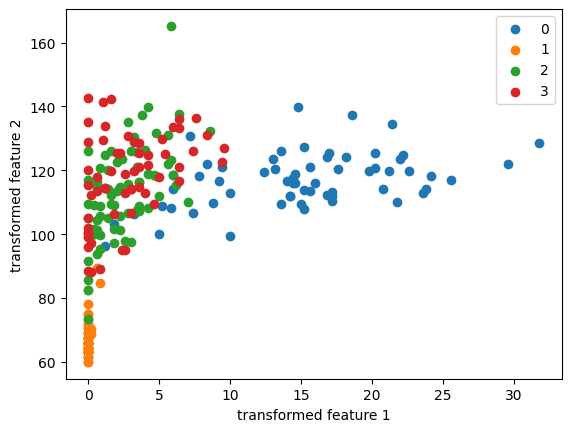

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

def plotGrid(transform, unit, linestyle=":", fig=None, ax=None):
    lim1 = -100
    lim2 = 100

    def mat2xy(start, end):
        if len(start.shape) == 1:
            start = np.expand_dims(start, 0)
            end = np.expand_dims(end, 0)
        nan = np.ones(len(start)) * np.nan
        x = np.stack((start[:, 0], end[:, 0], nan)).T.reshape(-1)
        y = np.stack((start[:, 1], end[:, 1], nan)).T.reshape(-1)
        return x, y

    def parallellines(axis, addend, lines, unit):
        addend = np.repeat(np.expand_dims(addend, 0), lines * 2, 0)
        unit = np.expand_dims(np.arange(-lines, lines) * unit, 1)
        unit = unit - lines
        addend = addend * unit
        lines = np.expand_dims(axis, 0) + addend
        return np.concatenate((lines, lines * -1))

    if fig is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    transform = transform.astype(float)
    xaxis = transform[0]
    yaxis = transform[1]


    lines1 = parallellines(xaxis * lim1, yaxis, 100, unit)
    lines2 = parallellines(xaxis * lim2, yaxis, 100, unit)
    x, y = mat2xy(lines1, lines2)
    plt.plot(x, y, linestyle + "k", linewidth=0.5)

    x, y = mat2xy(xaxis * lim1, xaxis * lim2)
    plt.plot(x, y, linestyle, color="#440077")


    lines1 = parallellines(yaxis * lim1, xaxis, 100, unit)
    lines2 = parallellines(yaxis * lim2, xaxis, 100, unit)
    x, y = mat2xy(lines1, lines2)
    plt.plot(x, y, linestyle + "k", linewidth=0.5)

    x, y = mat2xy(yaxis * lim1, yaxis * lim2)
    plt.plot(x, y, linestyle, color="#aa5500")

    return fig, ax

def plotData(X, y, xlabel="feature 1", ylabel="feature 2", fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots()
    for ii in range(nclasses):
        plt.scatter(X[y == ii, 0], X[y == ii, 1])
    plt.legend([str(i) for i in range(nclasses)])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    lim2 = X.max()
    lim1 = X.min()
    return fig, ax

def dist(a, b):
    diff = a - b
    sq = diff * diff
    return np.sqrt(sq.sum())

def NN1(traindata, trainlabel, query):
    diff = traindata - query
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label

def NN(traindata, trainlabel, testdata):
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel

def Accuracy(gtlabel, predlabel):
    assert len(gtlabel) == len(predlabel)
    correct = (gtlabel == predlabel).sum()
    return correct / len(gtlabel)

def cumArray(img):
    img2 = img.copy()
    for ii in range(1, img2.shape[1]):
        img2[ii, :] = img2[ii, :] + img2[ii - 1, :]
    img2 = img2 > 0
    return img2

def getHolePixels(img):
    im1 = cumArray(img)
    im2 = np.rot90(cumArray(np.rot90(img)), 3)
    im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
    im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
    hull = im1 & im2 & im3 & im4
    hole = hull & ~(img > 0)
    return hole

def getBoundaryPixels(img):
    img = img.copy() > 0
    rshift = np.roll(img, 1, 1)
    lshift = np.roll(img, -1, 1)
    ushift = np.roll(img, -1, 0)
    dshift = np.roll(img, 1, 0)
    boundary = (
        minus(img, rshift)
        | minus(img, lshift)
        | minus(img, ushift)
        | minus(img, dshift)
    )
    return boundary

def getHullPixels(img):
    im1 = cumArray(img)
    im2 = np.rot90(cumArray(np.rot90(img)), 3)
    im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
    im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
    hull = im1 & im2 & im3 & im4
    return hull

def minus(a, b):
    return a & ~b


(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255
test_X = test_X / 255

nclasses = 4

train_X = train_X[train_y < nclasses]
train_y = train_y[train_y < nclasses]
test_X = test_X[test_y < nclasses]
test_y = test_y[test_y < nclasses]

train_X = train_X[::100].copy()
train_y = train_y[::100].copy()
test_X = test_X[::100].copy()
test_y = test_y[::100].copy()

train_hole = np.array([getHolePixels(i).sum() for i in train_X])
test_hole = np.array([getHolePixels(i).sum() for i in test_X])
train_bound = np.array([getBoundaryPixels(i).sum() for i in train_X])
test_bound = np.array([getBoundaryPixels(i).sum() for i in test_X])
train_hull = np.array([getHullPixels(i).sum() for i in train_X])
test_hull = np.array([getHullPixels(i).sum() for i in test_X])
train_sum = np.sum(train_X, (1, 2)) / (28 * 28)
test_sum = np.sum(test_X, (1, 2)) / (28 * 28)


train_feats1 = np.vstack((train_hole, train_bound)).transpose()
test_feats1 = np.vstack((test_hole, test_bound)).transpose()
train_feats2 = np.vstack((train_hull, train_sum)).transpose()
test_feats2 = np.vstack((test_hull, test_sum)).transpose()

xlim = [-100, 300]
ylim = [-100, 300]

fig, ax = plotData(train_feats1, train_y, xlabel="hole", ylabel="bound")
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

test_pred = NN(train_feats1, train_y, test_feats1)
acc = Accuracy(test_y, test_pred)
print("Baseline accuracy with hole and boundary features:", acc * 100, "%", "for", nclasses, "classes")

fig, ax = plotData(train_feats2, train_y, xlabel="hull", ylabel="sum")
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

test_pred = NN(train_feats2, train_y, test_feats2)
acc = Accuracy(test_y, test_pred)
print("Baseline accuracy with hull and sum features:", acc * 100, "%", "for", nclasses, "classes")


transformation_matrices = [
    np.array([[1, 0], [0, 1]]),
    np.array([[0.5, -0.5], [0, 2.5]]),
    np.array([[2, 1], [1, 3]]),
    np.array([[0.2, -0.2], [0, 1.5]])
]

for transform in transformation_matrices:
    print("\nTransformation Matrix:\n", transform)

    train_feats1_t = np.matmul(train_feats1, transform)
    test_feats1_t = np.matmul(test_feats1, transform)
    fig, ax = plotData(train_feats1_t, train_y, xlabel="transformed feature 1", ylabel="transformed feature 2")



i thinks its different from previous one